<h1 id="Predicting house prices" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  Predicting house prices using advanced regression techniques </h1>

## Problem Definition
How well can we predict house prices for samples in test.csv file using advanced regression techniques

## Data
- train.csv Contains House sales samples (1460 sample) with 79 variables including SalePrice which is the dependent variable
- test.csv  Contains House sales samples (1460 sample) without SalePrice which is the variable we should predict
- data_description.txt full description of each variable

## Evaluation
- Goal

Predicting sale price for each sample (house) in test data. For each Id in the test set, we must predict the value of the SalePrice variable. 

- Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)


<h2 style="color:white;background:#0087B6;padding:8px;border-radius:8px">  What does this notebook contain? </h2>


*  Importing libraries and reading datasets
*  Dealing with missing values
    * Visualizing missing values percentage per column
    * Categorical features
    * Numeric features
        * Predicting LotFrontage missing values
        * Imputing other numeric features
*  Checking correlations
    * Correlation Matrix
    * Sorting correlations between features and SalePrice
    * Sorting Correlations between features
*   Important features Distribution
*   Feature engineering and Log Transformation
*   Encoding Categorical Features just using pandas
*   Discovering Outliers using Z-score
*   Time to modeling
    * Define variables and models
    * Train and validation report
    * Hyperparameter tuning with RandomizedSearchCV
*   Stacking ensemble of models
*   Feature importance
*   Predicting SalePrices for test data

<h1 id="1. Importing libraries and reading datasets" style="color:white;background:#0087B6;padding:8px;border-radius:8px">1. Importing libraries and reading datasets</h1>

### Importing libraries

In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import ExtraTreesRegressor
from scipy import stats

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set()


### Reading datasets
#### After reading train and test dataset, I'll combine them to for preprocessing

In [ ]:
#Reading datasets
train=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

#define train target
target=train['SalePrice']

#Combining train and test dataset for preprocessing
all_df=pd.concat([train,test], ignore_index=True,sort=False)

#Dropping SalePrice
all_df.drop('SalePrice',axis=1,inplace=True)

<h1 id="2. Dealing with missing values" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  2. Dealing with missing values </h1>

## Visualizing missing data

In [ ]:
missings_df={}
for key in all_df.columns:
    if all_df[key].isnull().sum() > 0:
        missings_df[key]=(all_df[key].isnull().sum()  /  len(all_df[key]) ) * 100

#Create missing values dataframe
missings_df=pd.DataFrame(missings_df,index=['MissingValues']).T.sort_values(by='MissingValues',ascending=False)

In [ ]:
#Plotting the percentage of missing values per column
plt.figure(figsize=(15,7),dpi=100)
plt.xticks(rotation=90)
sns.barplot(y=missings_df.MissingValues,x=missings_df.index, orient='v').set_title('The percentage of missing values per column')

 ## Missing values - Categorical features

In [ ]:
#Sort transposed describe() by count
all_df.describe(include='object').T.sort_values(by=['count']).head(10)

#### By looking at the data description I realized that the most missing values in the categorical features were supposed to be labeled as 'NA' (Not Available) . 

#### There are numeric variables related to the categorical ones which can assure us to fill them with 'NA'

In [ ]:
#Get the number of FirePlaces where Fire Place quality is missing
all_df[['FireplaceQu','Fireplaces']][all_df.FireplaceQu.isnull()]

In [ ]:
#Countplot the number of fireplaces
sns.countplot(x=all_df['Fireplaces'])
plt.ylabel('The number of houses')

### There are 1420 houses without fireplace

In [ ]:
#Get Garage car capacity where GarageQual is missing
all_df[['GarageQual','GarageCars']][all_df.GarageQual.isnull()]

In [ ]:
#Countplot the capacity of garages
sns.countplot(x=all_df['GarageCars'])
plt.ylabel('The number of houses')
plt.xlabel('The car capacity of garage')

### There are 159 houses without garage

### So let's fill categorical variables with 'Na'

In [ ]:
#Filling missing values for categorical features
all_df['Alley'].fillna('NA',inplace=True)
all_df['PoolQC'].fillna('NA',inplace=True)
all_df['Fence'].fillna('NA',inplace=True)
all_df['MiscFeature'].fillna('NA',inplace=True)
all_df['FireplaceQu'].fillna('NA',inplace=True)
all_df['GarageCond'].fillna('NA',inplace=True)
all_df['GarageQual'].fillna('NA',inplace=True)
all_df['GarageFinish'].fillna('NA',inplace=True)
all_df['GarageType'].fillna('NA',inplace=True)
all_df['BsmtExposure'].fillna('NA',inplace=True)
all_df['BsmtFinType2'].fillna('NA',inplace=True)
all_df['BsmtFinType1'].fillna('NA',inplace=True)
all_df['BsmtQual'].fillna('NA',inplace=True)
all_df['BsmtCond'].fillna('NA',inplace=True)

#### According to data dictionary there are features that do not contain the 'NA' category : 

In [ ]:
#Number of missing values for MasVnrType + unique categories
print("Number of missing values : ", all_df['MasVnrType'].isnull().sum())
print("Categories:", all_df['MasVnrType'].unique() )

In [ ]:
#Fill MasVnrType missing values with 'None'
all_df['MasVnrType'].fillna('None',inplace=True)

In [ ]:
#Getting categories for Electrical feature
print("Number of missing values : ", all_df['Electrical'].isnull().sum())
print("Categories:", all_df['Electrical'].unique() )

In [ ]:
#Fill with top freq
all_df['Electrical'].fillna('SBrkr',inplace=True)
 

In [ ]:
#Fill with top freq
all_df['MSZoning'].fillna('RL',inplace=True)
all_df['Utilities'].fillna('AllPub',inplace=True)
all_df['Functional'].fillna('Typ',inplace=True)
all_df['SaleType'].fillna('WD',inplace=True)
all_df['Exterior2nd'].fillna('VinylSd',inplace=True)
all_df['Exterior1st'].fillna('VinylSd',inplace=True)
all_df['KitchenQual'].fillna('TA',inplace=True)

 ## Missing values - numeric features

In [ ]:
#sorting transposed describe() by count 
all_df.describe().T.sort_values(by='count').head(10)

###  LotFrontage : 
#### There are other features related to the LotFrontage such as LotArea, Neighborhood,...

**Let's see how they related**

In [ ]:
#Plot Lotfrontage and LotArea distribution
fig,ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('LotFrontage And LotArea Distribution',size=15)
sns.histplot(x=all_df.LotFrontage,kde=True, ax=ax[0])
sns.histplot(x=all_df.LotArea,kde=True, ax=ax[1])


### Plot without outliers

In [ ]:
#Temp dataframe
Lot_tmp=all_df[['LotFrontage','LotArea']][~all_df.LotFrontage.isnull()]
#Calculating z-score to remove outliers
z = np.abs(stats.zscore(Lot_tmp))
#remove outliers
Lot_tmp_Z=Lot_tmp[(z < 3).all(axis=1)]


#### since they have diffrent range of numbers I'll take the sqrt of lotArea 


In [ ]:
##Plot Lotfrontage and LotArea distribution without outliers
fig,ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('LotFrontage And sqrt(LotArea) Distribution Without outliers',size=15)
sns.histplot(x=Lot_tmp_Z.LotFrontage,kde=True, ax=ax[0])
sns.histplot(x=Lot_tmp_Z.LotArea.apply(np.sqrt),kde=True, ax=ax[1])

### Relation between LotFrontage and LotArea

In [ ]:
# Plotting LotFrontage and LotArea
plt.figure(figsize=(10,5))
sns.regplot(x=Lot_tmp_Z.LotArea.apply(np.sqrt),y=Lot_tmp_Z.LotFrontage,
            line_kws={"color": "red"}).set(title='Relation Between LotFrontage And Sqrt(LotArea)')

#### so there is a rise for LotFrontage as the sqrt(LotArea) increases.

In [ ]:
#Relation between BldgType and LotFrontage
fig,ax = plt.subplots(1,2, figsize=(20,6))
sns.boxplot(x=all_df.BldgType,y=Lot_tmp_Z.LotFrontage, ax=ax[0]).set_title('BldgType (Type of dwelling) and LotFrontage',fontsize = 20)
sns.boxplot(x=all_df.GarageCars,y=Lot_tmp_Z.LotFrontage, ax=ax[1]).set_title('GarageCars and LotFrontage',fontsize = 20)

### Relation between neighborhood, LotFrontage, LotArea

In [ ]:
# Plotting LotFrontage, LotArea and Neighborhood
fig,ax=plt.subplots(2,1,figsize=(25,15))
sns.boxplot(x=all_df.Neighborhood,y=Lot_tmp_Z.LotFrontage,ax=ax[0]).set_title('LotFrontage And Neighborhood',fontsize=20)
sns.boxplot(x=all_df.Neighborhood,y=Lot_tmp_Z.LotArea.apply(np.sqrt),ax=ax[1]).set_title('LotArea And Neighborhood',fontsize=20)

### How about SalePrice and Neighborhood

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(25,8))
sns.boxplot(x=all_df[:1460].Neighborhood , y=target).set_title('Neighborhood And SalePrice',fontsize=20)

#### Overally, Houses in MeadowV, NPkVill, Blmngtn and Blueste neighborhoods have lower prices, lower LotArea and lower LotFrontage

## Training a model to predict missing values for LotFrontage
#### - I'll take a few columns as predictors 
#### - Then I'll compare the Mean absolute error for imputing with simple Median/Mean And regression Model

In [ ]:
#Creating temp dataframe and converting objects to dummies
LotFrontage_df=pd.get_dummies(all_df[['LandSlope','BldgType','Alley','LotConfig','MSZoning','Neighborhood','LotArea','LotFrontage']].copy())
#Replace Lotarea with it's Sqrt
LotFrontage_df['LotArea']=LotFrontage_df['LotArea'].apply(np.sqrt)

#Mask to access part of the dataframe with available LotFrontage
mask=~LotFrontage_df.LotFrontage.isnull()
#train dataset (including LotFrontage)
LotFrontage_train=LotFrontage_df.loc[mask]
#test dataset (Missing LotFrontage)
LotFrontage_Test=LotFrontage_df.loc[~mask].drop('LotFrontage',axis=1)
#Removing outliers from Train Dataframe 
z = np.abs(stats.zscore(LotFrontage_train[['LotFrontage','LotArea']]))
LotFrontage_train=LotFrontage_train[(z < 3).all(axis=1)]

#Define scaler
Scaler_L=StandardScaler()
#standardizing features
X=Scaler_L.fit_transform(LotFrontage_train.drop('LotFrontage',axis=1))
#Define target
y=LotFrontage_train['LotFrontage']
#Splitting Train dataframe
x_train,x_valid,y_train,y_valid=train_test_split(X, y ,test_size=0.3 , random_state=42)
#Defining model
model=GradientBoostingRegressor(n_estimators= 100, min_samples_split= 26, min_samples_leaf= 17, max_features='auto', max_depth= None)
#Fitting model on train data
model.fit(x_train,y_train)
#predicting validation target
y_pred=model.predict(x_valid)
#Storing mean absolute error for single mean, median and Gradien Boosting Regressor
GBoost_results= mean_absolute_error(y_valid,y_pred)
Mean_result= mean_absolute_error(y_valid,[y_valid.mean()]*len(y_valid))
Median_result= mean_absolute_error(y_valid,[y_valid.median()]*len(y_valid))
print("MEAN ABSOLUTE ERROR : ", GBoost_results)


In [ ]:
#Plotting train/validation results
fig, ax= plt.subplots(1,2,figsize=(20,6))
#Show results
sns.regplot(x=y_pred,y=y_valid, line_kws={'color':'red'} , ax=ax[0]).set(title='G-BOOOSTING Regressor Train and Validation Results',xlabel='LotFrontage (Predictions)',ylabel='LotFrontage (True)')
sns.barplot(x=["Mean","Median","GradientBoostingRegressor"],y=[Mean_result,Median_result,GBoost_results], ax=ax[1]).set(title='LotFrontage Imputation - Mean/Median Vs. GradientBoostingRegressor',ylabel='Mean absolute error')

#### Mean absolute error is twice lower for Gradient Boosting Regressor compared to the simple mean or median.

### Predict missing values for LotFrontage using trained model

In [ ]:
#Predicting Missing values for Lotfrontage
LotFrontage_Test=Scaler_L.transform(LotFrontage_Test)
LotFrontage_missings=model.predict(LotFrontage_Test)

#Fill Missing values
all_df.loc[~mask,'LotFrontage']=LotFrontage_missings

### Fill Other missing values

In [ ]:
#Exploring dataset to discover missing values
all_df.describe().T.sort_values(by='count').head(10)

### GarageYrBlt

In [ ]:
# Cheking GarageType where GarageYrBlt is missing 
all_df[['GarageYrBlt','GarageType']].loc[all_df.GarageYrBlt.isnull()]

#### Since there is no garage for these houses, it's not a good idea to fill these NaNs with the mean or median, it makes sense to fill it with 0

In [ ]:
# fill GarageYrBlt missings with the mean
all_df['GarageYrBlt'].fillna(0, inplace=True)

### Fill the rest of few missing values with median or 0

In [ ]:
#fill with median or 0
all_df['BsmtHalfBath'].fillna(all_df.BsmtHalfBath.median(), inplace=True)
all_df['BsmtFullBath'].fillna(all_df.BsmtFullBath.median(), inplace=True)
all_df['GarageCars'].fillna(0, inplace=True)
all_df['TotalBsmtSF'].fillna(all_df.TotalBsmtSF.median(), inplace=True)
all_df['BsmtUnfSF'].fillna(0 , inplace=True)
all_df['BsmtFinSF2'].fillna(all_df.BsmtFinSF2.median(), inplace=True)
all_df['GarageArea'].fillna(0, inplace=True)
all_df['BsmtFinSF1'].fillna(all_df.BsmtFinSF1.median(), inplace=True)
all_df['MasVnrArea'].fillna(all_df['MasVnrArea'].median(), inplace=True)


#### save dataframe without missing values

In [ ]:
#Saving dataframe
all_df.to_csv('Imputed_data_all.csv')

<h1 id="Checking Correlations" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  3.  Checking Correlations </h1>

## Correlation Matrix

In [ ]:
#Get the correlation matrix
corr=train.corr()

# Getting the Upper Triangle of the co-relation matrix
UpperT = np.triu(corr)
plt.figure(figsize=(20,15))
plt.title('Correlation Matrix')
sns.heatmap(corr, mask=UpperT)

<h2> <a style="color:black" href="https://www.kaggle.com/mehrdadsadeghi/house-price-advanced-regression-techniques">Sort highly correlated features </a> with SalePrice </h2>

In [ ]:
#Getting sorted correlation between features and SalePrice 
train.corrwith(target).sort_values(ascending=False).head(50)

 Correlation >  0.60 :

- OverallQual : (Rates the overall material and finish of the house - 1 to 9 )
- GrLivArea   : (Above grade (ground) living area square feet)
- GarageCars  : (Size of garage in car capacity)
- GarageArea  : (Size of garage in square feet)
- TotalBsmtSF : (Total square feet of basement area)
- 1stFlrSF    : (First Floor square feet)

## Correlation between features
#### following function calculates correlation in pairs and returns a dataframe

In [ ]:
def highly_correlated(df, features, threshold=0.5):
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value
    correlation_df={}
    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            correlation_df[corr_df.index[i] +" and "+ corr_df.columns[j]]= v
        correlation_df=pd.DataFrame(correlation_df,index=['Correlation'])
    return  correlation_df.T.sort_values(by='Correlation',ascending=False)


In [ ]:
#print correlation between features
highly_correlated(all_df,all_df.columns).style.set_properties(**{'background-color': 'black','color': 'white'})

<h1 id="4. Distribution of Important features" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  4. Distribution of Important features</h1> 

In [ ]:
#plotting histogram chart for highly correlated features 
fig, ax = plt.subplots(5,2,figsize=(20,22),dpi=100)
fig.suptitle('Distribution of Highly Correlated Features',size=20)
sns.histplot(all_df['GarageCars'],ax=ax[0,0])
sns.histplot(all_df.GarageArea,ax=ax[0,1])
sns.histplot(all_df.YearBuilt,ax=ax[1,0])
sns.histplot(all_df.GarageYrBlt ,ax=ax[1,1])
sns.histplot(all_df.GrLivArea,ax=ax[2,0])
sns.histplot(all_df['TotRmsAbvGrd'],ax=ax[2,1])
sns.histplot(all_df['TotalBsmtSF'],ax=ax[3,0])
sns.histplot(all_df['1stFlrSF'],ax=ax[3,1])
sns.histplot(all_df['BedroomAbvGr'],ax=ax[4,0])
sns.histplot(all_df['2ndFlrSF'],ax=ax[4,1])

<h1 id=" 5. Feature engineering" style="color:white;background:#0087B6;padding:8px;border-radius:8px">  5. Feature engineering and log transformation </h1>

<b> Since there is high correlation between Yearbuilt and GarageYrBlt  I'll drop the GarageYrBlt. </b>


In [ ]:
#Creating a copy of data
all_df_copy=all_df.copy()
#Drop GarageYrBlt
all_df_copy.drop('GarageYrBlt', axis=1,inplace=True)

#### I dont want to drop other features for now, instead of that I'll use them to create new features like Log-scaled GrLivArea, Total_Square_Feet , ...

### Adding new predictors

In [ ]:
all_df_copy['Log_GrLivArea'] = all_df_copy['GrLivArea'].apply(np.log)
all_df_copy['Log_1stFlrSF'] = all_df_copy['1stFlrSF'].apply(np.log) 
all_df_copy['Log_LotFrontage']= all_df_copy['LotFrontage'].apply(np.log) 
all_df_copy['Sqrt_LotArea']=all_df_copy['LotArea'].apply(np.log)   
all_df_copy['HouseAge']=all_df_copy['YrSold']-all_df_copy['YearBuilt']
all_df_copy['Total_Rooms']= all_df_copy['BedroomAbvGr'] + all_df_copy['TotRmsAbvGrd']  
all_df_copy['GrLivArea_Score']= np.sqrt(all_df_copy['OverallQual']) * all_df_copy['GrLivArea']
all_df_copy['Total_Square_Feet'] = all_df_copy.TotalBsmtSF + all_df_copy['1stFlrSF'] + all_df_copy['2ndFlrSF']
all_df_copy['Total_Porch'] = all_df_copy.ScreenPorch + all_df_copy.EnclosedPorch + all_df_copy.OpenPorchSF + all_df_copy.WoodDeckSF + all_df_copy['3SsnPorch']
all_df_copy['OverallQualCond'] = (all_df_copy['OverallCond'] * all_df_copy.OverallQual)
all_df_copy['BsmtFinSF']=all_df_copy['BsmtFinSF1'] + all_df_copy['BsmtFinSF2'] 
all_df_copy['TotalBath_Abv']=2*all_df_copy['FullBath']+all_df_copy['HalfBath']*0.5
all_df_copy['TotalBath_Bsmt']=2*all_df_copy['BsmtFullBath']+all_df_copy['BsmtHalfBath']*0.5

### Get columns containing  Na, Fa, Ta, Gd, Ex,..

In [ ]:
tmp_cols=all_df_copy.columns[all_df_copy.isin(['Gd']).any()]
tmp_cols

### Replace marks with numbers

In [ ]:
#Make a dict
marks = {'No':0,'None':0,'NA':0,'Mn':1,'Av':3, "Po": 1, 'Fa': 2, "TA": 3, 'Gd': 4, 'Ex': 5}
#Apply map for each column
for column in tmp_cols:
    all_df_copy[column]=all_df_copy[column].map(marks)

### Combine ExterCond,ExterQual and GarageQual,GarageCond

In [ ]:
all_df_copy['Exter_Overall'] = all_df_copy['ExterCond'] * all_df_copy['ExterQual']
all_df_copy['Garage_Overall'] = all_df_copy['GarageQual'] * all_df_copy['GarageCond']

### Important features price chart

In [ ]:
#plotting most correlated features based on SalePrice
fig, ax = plt.subplots(3,2,figsize=(20,18))
fig.suptitle('Important features and Sale Price',size=20)
sns.regplot(x=target,y=all_df_copy[:1460].OverallQual,ax=ax[0,0])
sns.regplot(x=target,y=all_df_copy[:1460].GrLivArea,ax=ax[0,1])
sns.regplot(x=target,y=all_df_copy[:1460].GarageCars,ax=ax[1,0])
sns.regplot(x=target,y=all_df_copy[:1460]['1stFlrSF'],ax=ax[1,1])
sns.regplot(x=target,y=all_df_copy[:1460].FullBath,ax=ax[2,0])
sns.regplot(x=target,y=all_df_copy[:1460]['YearBuilt'],ax=ax[2,1])

#### As a result of Non-normal distribution of X-axis (SalePrice) samples are concentrated on the left

## Sale Price Log Transformation

In [ ]:
#Plotting Sale Price distribiution
fig,ax=plt.subplots(1,2,figsize=(20,5),dpi=100)
fig.suptitle('Distribution of SalePrice',size=15)
sns.histplot(target, ax=ax[0],kde=True).set_title('SalePrice')
sns.histplot(target.apply(np.log),kde=True, ax=ax[1]).set_title('SalePrice - Log-Scale')

In [ ]:
#taking SalePrice into logarithmic scale
target=target.apply(np.log)

<h1 id="6. Encoding Categorical Features" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:left"> 6. Encoding Categorical Features Using Pandas </h1>

<h3>  Change the type of strings into category data type </h3>


In [ ]:
#Create copy
all_df_copy_en=all_df_copy.copy()

#Converting objects data type to category data type
for key,value in all_df_copy_en.items():
    if pd.api.types.is_string_dtype(value):
        all_df_copy_en[key] = value.astype("category").cat.as_ordered()

<h3> Replace categories with their codes  </h3>

In [ ]:
#Replace categories with their code
for key,value in all_df_copy_en.items():
     if not pd.api.types.is_numeric_dtype(value):
        all_df_copy_en[key] = pd.Categorical(value).codes+1
        
#Get Dummy variables
#all_df_copy_D=pd.get_dummies(all_df_copy).drop('Id',axis=1) # not used

### Splitting data to train/test

#### Before dealing with outliers I have to split the combined dataframes to train and test, because we want to remove outliers only from train dataset

In [ ]:
#Drop id column
all_df_copy_en.drop('Id',axis=1,inplace=True)
#Split data after encoding
train_df=all_df_copy_en[:1460].copy()
train_df['SalePrice']=target
test_df=all_df_copy_en[1460:].copy()

<h1 id="7. Discovering Outliers" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:left"> 7. Discovering Outliers using Z-score </h1>

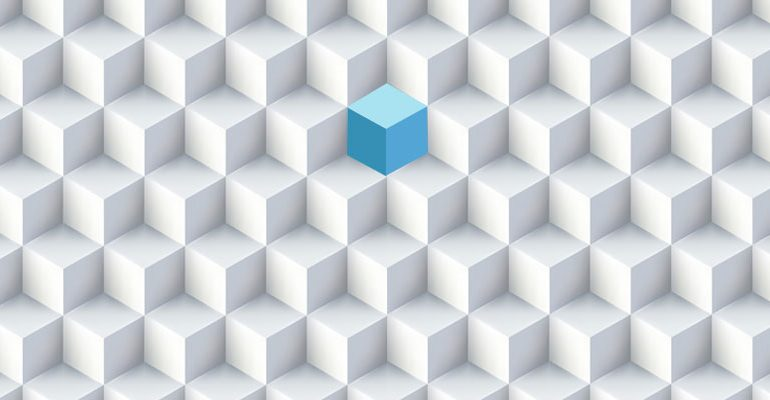 

### What is Z-score ? 
#### Also called standard score. This score helps to understand if a data value is greater or smaller than mean and how far away it is from the mean. More specifically, Z score tells how many standard deviations away a data point is from the mean.

#### Z score = (x -mean) / std

#### Calculating z-score : 

In [ ]:
#columns for z-score calculation
numeric_columns=train_df.columns 
#Calculating z-score using stats library
z = np.abs(stats.zscore( train_df[numeric_columns]))

#train_df.select_dtypes(include=[np.number]).columns.values  // Returns only numeric columns

#### I'll define a Temporary dataframe and keep the previous one safe

#### With the knowledge we have gained from the data so far, By changing Z value for several times and observing results we can finally decide what should be the right value for Z 

In [ ]:
#Removing outliers on temporary dataframe
train_df_z=train_df.copy()[(z < 10).all(axis=1)]

print('Rows,columns Before removing outliers : ', train_df.shape )
print('Rows,columns After removing outliers : ', train_df_z.shape )

#### Plot features after removing outliers

In [ ]:
#plotting important features
fig, ax = plt.subplots(4,2,figsize=(18,18))
fig.suptitle('Log-SalePrice and Important Features Without Outliers', size=20)
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z.OverallQual,ax=ax[0,0], line_kws={'color':'red'})
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z.Log_GrLivArea,ax=ax[0,1], line_kws={'color':'red'})
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z.GarageCars,ax=ax[1,0], line_kws={'color':'red'})
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z['Log_1stFlrSF'],ax=ax[1,1], line_kws={'color':'red'})
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z.TotalBsmtSF ,ax=ax[2,0], line_kws={'color':'red'})
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z['YearBuilt'],ax=ax[2,1], line_kws={'color':'red'})
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z.FullBath ,ax=ax[3,0], line_kws={'color':'red'})
sns.regplot(x=train_df_z['SalePrice'],y=train_df_z['TotRmsAbvGrd'],ax=ax[3,1], line_kws={'color':'red'})

<h1 id="8. Time to modeling" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:left"> 8. Time to modeling </h1>

### Making a to_drop list

In [ ]:
#Add features to dropFullBath
to_drop=['SalePrice','Fence',
                    'HalfBath',
                    'FullBath',
                    'BsmtFullBath',
                     'BsmtHalfBath',
                     'LotConfig',
                     'Foundation',
                     'BsmtFinSF2',
                     'LotShape',
                     'MSSubClass',
                     'PoolArea',
                     'LandContour',
                     'LandSlope',
                     'BsmtHalfBath',
                     'MasVnrArea',
                     'PavedDrive',
                     'GarageFinish',
                     'MasVnrType',
                     'HeatingQC',
                     'SaleType',
                     '3SsnPorch',
                     'PoolQC',
                     'ScreenPorch',
                     'MiscFeature',
                     'Street',
                     'MiscVal',
                     'GarageArea',
                     'YearRemodAdd',
                     'YearBuilt',
                     'LotArea',
                     'GrLivArea',
                     'LotFrontage',
                     'RoofMatl',
                     'Alley',
                     'RoofStyle',
                     'Heating',
                     'BsmtFinType2',
                     'BsmtFinType1',
                     'LowQualFinSF',
                     'MoSold', 
                     '1stFlrSF',
                     '2ndFlrSF',
                     'OverallQual',
                     'OverallCond',
                     'TotalBsmtSF',
                     'YrSold',
                     'BsmtFinSF1',
                     'ExterCond',
                     'ExterQual',
                     'GarageQual',
                     'GarageCond',
                     'BsmtFinSF2']
#will be dropped from test data
to_drop_t=to_drop[1:]

## Define dependent and independent variables

In [ ]:
#Independent variables 
X=train_df_z.drop(to_drop,axis=1)
#Dependent variable
y=train_df_z['SalePrice']

#scaling features
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#spliting train dataset to train and validation
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

## Define score functions

In [ ]:
# evaluate a given model by making predictions on X_valid
def get_v_score(model):
    valid_predictions=model.predict(X_valid)
    score=np.sqrt(mean_squared_error(y_valid, valid_predictions))
    return score

# evaluate a given model using cross-validation
def get_cv_score(model, X, y):
    #cv = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1))
    return np.mean(scores)

## Define models 

In [ ]:
# Models name
models_name=['RandomForestRegressor',
             'GradientBoostingRegressor',
             'XGBRegressor',
             'svm.SVR',
             'ExtraTreesRegressor',
             'Lasso']
# Models
models=[RandomForestRegressor(),
        GradientBoostingRegressor(),
        XGBRegressor(),
        svm.SVR(),
        ExtraTreesRegressor(),
        Lasso(alpha=0.0005,tol=0.001)]

## Get score for each model 

In [ ]:
#Fit and get scores for each model
scores_list=[]
for model in models:
    model.fit(X_train,y_train)
    scores_list.append(get_v_score(model))

In [ ]:
#Convert list to dataframe
data={'Model':models_name,'RMSE': scores_list}
scores_df=pd.DataFrame(data)
#Sort by valid RMSLE
scores_df.sort_values(by='RMSE').round(5).style.set_properties(**{'background-color': 'black','color': 'white'})

## Hyperparameter tuning

#### I've used RandomizedSearchCv to get the best parameters for each model and use them in the next section 

In [ ]:
#Hyperparameter tuning with RandomizedSearchC 
#GBOOST_grid = {"max_depth" :  np.arange(2, 10, 1),
               #"splitter" : ['best','random'],
#               "min_samples_split": np.arange(2, 100, 1),
#               "min_samples_leaf" : np.arange(2, 100, 1),}
#GBOOST_model = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=GBOOST_grid, n_iter=100, cv=5, verbose=True)
#GBOOST_model.fit(X_train, y_train)
#Show best parameters
#print("Best Params : ", GBOOST_model.best_params_)

<h1 id="9. Stacking models with best parameters" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:left"> 9. Stacking models with best parameters </h1>

### Stacking Models

In [ ]:
# get a stacking ensemble of models
def get_stacking():
   
    # define the base models with tuned parameters
    level0 = list()
    level0.append(('GBOOST', GradientBoostingRegressor(min_samples_split=90, min_samples_leaf=26)))
    level0.append(('RandomForest', RandomForestRegressor(min_samples_split=14, min_samples_leaf=8)))
    level0.append(('XGB', XGBRegressor(colsample_bytree=0.6, gamma=0.4 )))
    level0.append(('ExtraTrees', ExtraTreesRegressor(min_samples_split=14, min_samples_leaf=2)))
    level0.append(('svm.SVR', svm.SVR(kernel='poly',gamma='scale',degree=1,coef0=0.30000000000000004)))
    level0.append(('ElasticNet', ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=0,tol=0.001)))
    level0.append(('Lasso', Lasso(alpha=0.0005, tol=0.001)))

    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

#Add to models list
models_name.append('StackingRegressor')
models.append(get_stacking())

## Fit stacked model and get validation score 

In [ ]:
#Fit stacked model and get validation score
Stackedmodel=get_stacking()
Stackedmodel.fit(X_train,y_train)
print('RMSE : ', get_v_score(Stackedmodel))

In [ ]:
y_pred=Stackedmodel.predict(X_valid)
sns.regplot(x=y_pred, y=y_valid).set_title("Stackedmodel Results")
plt.xlabel("Predicted")
plt.ylabel("True values")

<h1 id="10. Feature importance" style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:left"> 10. Feature importance </h1>

#### Feature importance by gradient boosting regressor

In [ ]:
Gboost=GradientBoostingRegressor(min_samples_split=26, min_samples_leaf=29)
Gboost.fit(X_train,y_train)

#create feature importance dataframe
FI_df=pd.DataFrame({'Features': X.columns, 'Importance': Gboost.feature_importances_})
FI_df=FI_df.sort_values(by='Importance', ascending=False).head(100)

#plot feature importance
plt.figure(figsize=(15,10),dpi=100)
sns.barplot(x=FI_df[:30].Importance,y=FI_df[:30].Features,orient = 'h').set_title('Feature Importance')

<h1 id="11. Making prediction on test data " style="color:white;background:#0087B6;padding:8px;border-radius:8px;text-align:left"> 11. Making prediction on test data </h1>

In [ ]:
#Scaling Test data
test_df_Scaled=scaler.transform(test_df.drop(to_drop_t,axis=1))
#Getting predictions
test_df_preds=Stackedmodel.predict(test_df_Scaled)

#Adding Id column
test_preds=pd.DataFrame({'Id':test['Id'],'SalePrice':(np.exp(test_df_preds))})
test_preds

In [ ]:
#Save predictions
test_preds.to_csv('submission.csv', index=False)

#### Credits
* [Stacking Ensemble Machine Learning With Python by Jason Brownlee](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/)
* https://www.kaggle.com/niekvanderzwaag/housing-price-prediction-regression
* https://www.kaggle.com/lovroselic/houseprices-ls
* https://towardsdatascience.com